# Physical processes contributing to (re)stratification

In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import seaborn as sns
from scipy import signal
from scipy.stats import pearsonr
sns.set_style('dark')
from info import datadir, figdir

import warnings
warnings.filterwarnings('ignore')

### Loading data

In [2]:
data = pd.read_csv(datadir+'annual_timeseries.csv',index_col=0)
conv = data['conv']
restrat_all_upper = data['restrat_all_upper']
restrat_all_lower = data['restrat_all_lower']
mins_all_upper = data['mins_all_upper']
maxs_all_upper = data['maxs_all_upper']
mins_all_lower = data['mins_all_lower']
maxs_all_lower = data['maxs_all_lower']

data = pd.read_csv(datadir+'monthly_timeseries.csv',index_col=0)
dates = pd.to_datetime(data['dates'])
SI_all_upper = data['SI_all_upper']
SI_all_lower = data['SI_all_lower']
E = data['E']
P = data['P']
E_P = data['E_P']
Q = data['Q']

SI_max_upper = np.array([SI_all_upper[maxs_all_upper[i]] for i in range(len(maxs_all_upper))])
SI_min_upper = np.array([SI_all_upper[mins_all_upper[i]] for i in range(len(mins_all_upper))])
SI_max_lower = np.array([SI_all_lower[maxs_all_lower[i]] for i in range(len(maxs_all_lower))])
SI_min_lower = np.array([SI_all_lower[mins_all_lower[i]] for i in range(len(mins_all_lower))])

In [3]:
# Hydrographic section EKE data
data_section = sio.loadmat(datadir+'hydrographic_sections.mat')
EKE_section = data_section['EKE']
# Select only surface values
EKE_surf = EKE_section[:,0,:]
# Select only values to the east of the DCA boundary (see plot_hydrographic_sections: index 62)
EKE_surf_east = EKE_surf[:,62:]
# Average over the points along the section
EKE_av = np.average(EKE_surf_east,axis=1)

In [4]:
time = range(len(dates))
def set_xrange(ax):
    ax.set_xlim(time[0]-2,time[-1]-5)
    ax.set_xticks(time[0::24])
    ax.set_xticklabels([dates[i].year for i in np.arange(0,len(time[0::24])*24,24)],fontsize=11)

def plotAnnual(ax,data,color,label,start=0,label_black=True):
    ax.scatter(time[start::12],data,color=color)
    ax.plot(time[start::12],data,color=color)
    if label_black:
        ax.set_ylabel(label, fontsize=13,color='k')
        ax.tick_params(axis='y',labelsize=12,labelcolor='k')
    else:
        ax.set_ylabel(label, fontsize=13,color=color)
        ax.tick_params(axis='y',labelsize=12,labelcolor=color)

        
def plotCorr(ax,data1,data2,xpos=50,ypos=40):
    corr, pval = pearsonr(data1,data2)
    xpos = xpos
    ypos = ypos
    if pval<0.05: # significant correlation: print bold
        ax.text(xpos,ypos,'$r = $'+str(np.round(corr,3)),fontsize=15,c='k',fontweight='bold')
    else:
        ax.text(xpos,ypos,'$r = $'+str(np.round(corr,3)),fontsize=15,c='k')   

    
cmap = matplotlib.cm.get_cmap('cmo.dense')
cmap_T = matplotlib.cm.get_cmap('cmo.thermal')
cmap_S = matplotlib.cm.get_cmap('cmo.haline')
cmap_EKE = matplotlib.cm.get_cmap('cmo.matter')

## Min strat, max strat, restrat

Correlations max/min strat / restrat from 2001 onward

In [5]:
def significant(pval):
    if pval < 0.05:
        return 'significant'
    else:
        return 'not significant'

In [6]:
# Upper layer

corr, pval = pearsonr(restrat_all_upper[8:],SI_max_upper[8:])
print('Corrcoeff restrat/max strat upper layer: %.4f'%corr+', '+significant(pval))

corr, pval = pearsonr(restrat_all_upper[8:],SI_min_upper[8:])
print('Corrcoeff restrat/min strat upper layer: %.3f'%corr+', '+significant(pval))

corr, pval = pearsonr(SI_max_upper[8:],SI_min_upper[8:])
print('Corrcoeff max/min strat upper layer: %.3f'%corr+', '+significant(pval))

Corrcoeff restrat/max strat upper layer: 0.9999, significant
Corrcoeff restrat/min strat upper layer: -0.009, not significant
Corrcoeff max/min strat upper layer: 0.003, not significant


In [7]:
# Lower layer

corr, pval = pearsonr(restrat_all_lower[8:],SI_max_lower[8:])
print('Corrcoeff restrat/max strat lower layer: %.3f'%corr+', '+significant(pval))

corr, pval = pearsonr(restrat_all_lower[8:],SI_min_lower[8:])
print('Corrcoeff restrat/min strat lower layer: %.3f'%corr+', '+significant(pval))

corr, pval = pearsonr(SI_max_lower[8:],SI_min_lower[8:])
print('Corrcoeff max/min strat lower layer: %.3f'%corr+', '+significant(pval))

Corrcoeff restrat/max strat lower layer: 0.803, significant
Corrcoeff restrat/min strat lower layer: 0.433, not significant
Corrcoeff max/min strat lower layer: 0.885, significant


## Upper layer: surface fluxes during restratification period

In [8]:
yrs = len(mins_all_upper)
days_month = 30 # average number of days in a month
E_summer = np.zeros(yrs)
P_summer = np.zeros(yrs)
E_P_summer = np.zeros(yrs)
Q_summer = np.zeros(yrs)
for i in range(yrs):
    for j in range(mins_all_upper[i]+1,maxs_all_upper[i]+1):
        E_summer[i] += E[j]
        P_summer[i] += P[j]
        E_P_summer[i] += E_P[j]
        Q_summer[i] += Q[j]*days_month

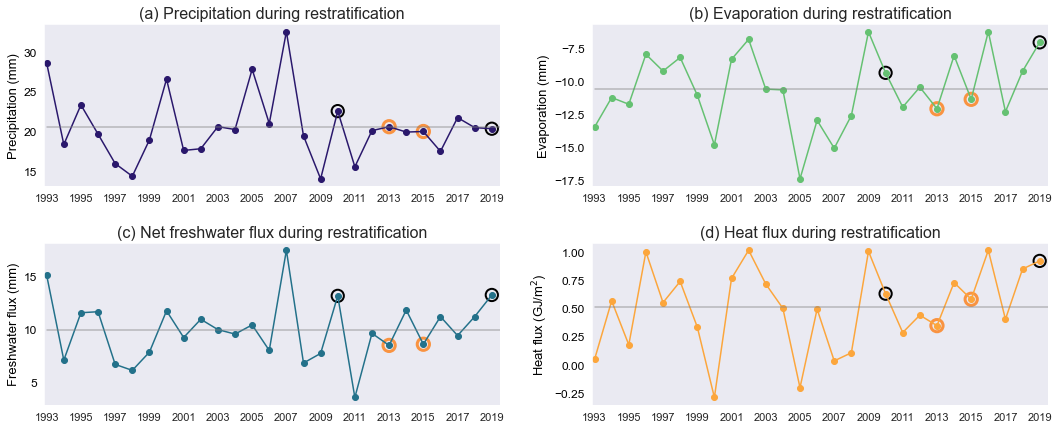

In [9]:
sns.set_style('dark')
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(18,7))
set_xrange(ax1)
set_xrange(ax2)
set_xrange(ax3)
set_xrange(ax4)

plotAnnual(ax1,P_summer*1e3,cmap_S(0),'Precipitation (mm)')
ax1.set_title('(a) Precipitation during restratification',fontsize=16)
ax1.plot(time,np.ones(len(time))*np.mean(P_summer*1e3),color='gray',alpha=0.5)
ax1.scatter(time[12*17],P_summer[17]*1e3,s=150,facecolor='none',edgecolor='k',linewidth=2)
ax1.scatter(time[12*26],P_summer[26]*1e3,s=150,facecolor='none',edgecolor='k',linewidth=2)
ax1.scatter(time[12*20],P_summer[20]*1e3,s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)
ax1.scatter(time[12*22],P_summer[22]*1e3,s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)

plotAnnual(ax2,E_summer*1e3,cmap_S(0.7),'Evaporation (mm)')
ax2.set_title('(b) Evaporation during restratification',fontsize=16)
ax2.plot(time,np.ones(len(time))*np.mean(E_summer*1e3),color='gray',alpha=0.5)
ax2.scatter(time[12*17],E_summer[17]*1e3,s=150,facecolor='none',edgecolor='k',linewidth=2)
ax2.scatter(time[12*26],E_summer[26]*1e3,s=150,facecolor='none',edgecolor='k',linewidth=2)
ax2.scatter(time[12*20],E_summer[20]*1e3,s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)
ax2.scatter(time[12*22],E_summer[22]*1e3,s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)

plotAnnual(ax3,E_P_summer*1e3,cmap_S(0.35),'Freshwater flux (mm)')
ax3.set_title('(c) Net freshwater flux during restratification',fontsize=16)
ax3.plot(time,np.ones(len(time))*np.mean(E_P_summer*1e3),color='gray',alpha=0.5)
ax3.scatter(time[12*17],E_P_summer[17]*1e3,s=150,facecolor='none',edgecolor='k',linewidth=2)
ax3.scatter(time[12*26],E_P_summer[26]*1e3,s=150,facecolor='none',edgecolor='k',linewidth=2)
ax3.scatter(time[12*20],E_P_summer[20]*1e3,s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)
ax3.scatter(time[12*22],E_P_summer[22]*1e3,s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)

plotAnnual(ax4,Q_summer/1e9,cmap_T(0.8),'Heat flux (GJ/m$^2$)')
ax4.set_title('(d) Heat flux during restratification',fontsize=16)
ax4.plot(time,np.ones(len(time))*np.mean(Q_summer/1e9),color='gray',alpha=0.5)
ax4.scatter(time[12*17],Q_summer[17]/1e9,s=150,facecolor='none',edgecolor='k',linewidth=2)
ax4.scatter(time[12*26],Q_summer[26]/1e9,s=150,facecolor='none',edgecolor='k',linewidth=2)
ax4.scatter(time[12*20],Q_summer[20]/1e9,s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)
ax4.scatter(time[12*22],Q_summer[22]/1e9,s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)

plt.subplots_adjust(hspace=0.35)
plt.savefig(figdir+'restrat_fluxes.png',bbox_inches='tight')
plt.show()

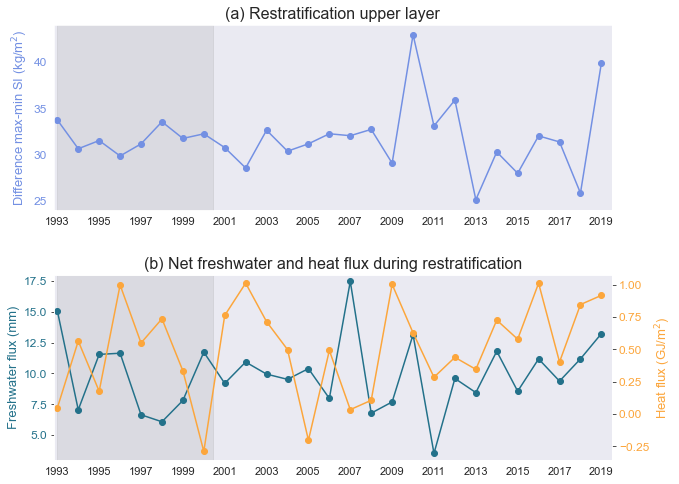

In [10]:
sns.set_style('dark')
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
ax22 = ax2.twinx()
set_xrange(ax1)
set_xrange(ax2)

ax1.fill_between(time[0:int(12*7.5)],np.ones(int(12*7.5))*44,alpha=0.15,color='gray')
plotAnnual(ax1,restrat_all_upper,cmap(0.4),'Difference max-min SI (kg/m$^2$)',label_black=False)
ax1.set_ylim(24,44)
ax1.set_title('(a) Restratification upper layer',fontsize=16)

ax2.fill_between(time[0:int(12*7.5)],np.ones(int(12*7.5))*18,alpha=0.15,color='gray')
plotAnnual(ax2,E_P_summer*1e3,cmap_S(0.35),'Freshwater flux (mm)',label_black=False)
ax2.set_ylim(3,18)
plotAnnual(ax22,Q_summer/1e9,cmap_T(0.8),'Heat flux (GJ/m$^2$)',label_black=False)
ax2.set_title('(b) Net freshwater and heat flux during restratification',fontsize=16)

plt.subplots_adjust(hspace=0.35)
plt.savefig(figdir+'processes_upper.png',bbox_inches='tight')
plt.show()

In [11]:
corr, pval = pearsonr(restrat_all_upper[8:],E_P_summer[8:])
print('Corrcoeff restrat upper layer and freshwater flux: %.3f'%corr+', '+significant(pval))

corr, pval = pearsonr(restrat_all_upper[8:],Q_summer[8:])
print('Corrcoeff restrat upper layer and heat flux: %.3f'%corr+', '+significant(pval))

Corrcoeff restrat upper layer and freshwater flux: 0.270, not significant
Corrcoeff restrat upper layer and heat flux: -0.015, not significant


## Lower layer: max MLD before and mean EKE during restratification

In [12]:
yrs = len(mins_all_upper)
EKE_summer = np.zeros(yrs)
for i in range(yrs):
    duration = maxs_all_lower[i] - mins_all_lower[i]
    for j in range(mins_all_lower[i]+1,maxs_all_lower[i]+1):
        EKE_summer[i] += EKE_av[j]/duration

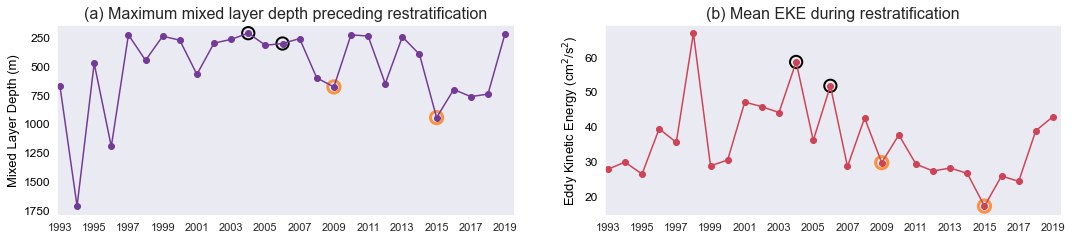

In [13]:
sns.set_style('dark')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,3.5))
set_xrange(ax1)
set_xrange(ax2)

plotAnnual(ax1,conv,cmap(0.7),'Mixed Layer Depth (m)')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_title('(a) Maximum mixed layer depth preceding restratification',fontsize=16)
ax1.scatter(time[12*11],conv[11],s=150,facecolor='none',edgecolor='k',linewidth=2)
ax1.scatter(time[12*13],conv[13],s=150,facecolor='none',edgecolor='k',linewidth=2)
ax1.scatter(time[12*16],conv[16],s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)
ax1.scatter(time[12*22],conv[22],s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)

plotAnnual(ax2,EKE_summer*1e4,cmap_EKE(0.5),'Eddy Kinetic Energy (cm$^2$/s$^2$)')
ax2.set_title('(b) Mean EKE during restratification',fontsize=16)
ax2.scatter(time[12*11],EKE_summer[11]*1e4,s=150,facecolor='none',edgecolor='k',linewidth=2)
ax2.scatter(time[12*13],EKE_summer[13]*1e4,s=150,facecolor='none',edgecolor='k',linewidth=2)
ax2.scatter(time[12*16],EKE_summer[16]*1e4,s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)
ax2.scatter(time[12*22],EKE_summer[22]*1e4,s=150,facecolor='none',edgecolor=cmap_T(0.75),linewidth=3)

plt.savefig(figdir+'restrat_EKE_MLD.png',bbox_inches='tight')
plt.show()

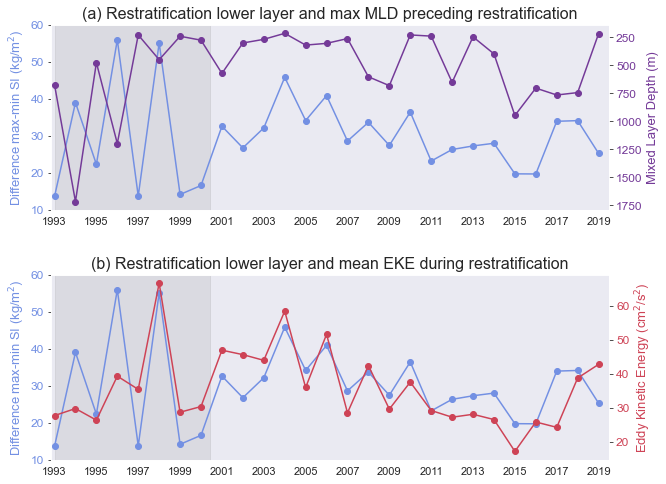

In [14]:
sns.set_style('dark')
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
ax11 = ax1.twinx()
ax22 = ax2.twinx()
set_xrange(ax1)
set_xrange(ax2)

ax1.fill_between(time[0:int(12*7.5)],np.ones(int(12*7.5))*60,alpha=0.15,color='gray')
plotAnnual(ax1,restrat_all_lower,cmap(0.4),'Difference max-min SI (kg/m$^2$)',label_black=False)
ax1.set_ylim(10,60)
plotAnnual(ax11,conv,cmap(0.7),'Mixed Layer Depth (m)',label_black=False)
ax11.set_ylim(ax11.get_ylim()[::-1])
ax1.set_title('(a) Restratification lower layer and max MLD preceding restratification',fontsize=16)

ax2.fill_between(time[0:int(12*7.5)],np.ones(int(12*7.5))*60,alpha=0.15,color='gray')
plotAnnual(ax2,restrat_all_lower,cmap(0.4),'Difference max-min SI (kg/m$^2$)',label_black=False)
ax2.set_ylim(10,60)
plotAnnual(ax22,EKE_summer*1e4,cmap_EKE(0.5),'Eddy Kinetic Energy (cm$^2$/s$^2$)',label_black=False)
ax2.set_title('(b) Restratification lower layer and mean EKE during restratification',fontsize=16)

plt.subplots_adjust(hspace=0.35)
plt.savefig(figdir+'processes_lower.png',bbox_inches='tight')
plt.show()

In [15]:
corr, pval = pearsonr(SI_min_lower[8:],conv[8:])
print('Corrcoeff min strat lower layer and MLD: %.3f'%corr+', '+significant(pval))

corr, pval = pearsonr(SI_max_lower[8:],conv[8:])
print('Corrcoeff max strat lower layer and MLD: %.3f'%corr+', '+significant(pval))

corr, pval = pearsonr(restrat_all_lower[8:],conv[8:])
print('Corrcoeff restrat lower layer and MLD: %.3f'%corr+', '+significant(pval))

corr, pval = pearsonr(restrat_all_lower[8:],EKE_summer[8:])
print('Corrcoeff restrat lower layer and EKE: %.3f'%corr+', '+significant(pval))

Corrcoeff min strat lower layer and MLD: -0.877, significant
Corrcoeff max strat lower layer and MLD: -0.752, significant
Corrcoeff restrat lower layer and MLD: -0.334, not significant
Corrcoeff restrat lower layer and EKE: 0.733, significant
